In [1]:
#pip install Clustimage
#pip install tensorflow
#pip install keras

In [ ]:
#Link al dataset = https://www.muratkoklu.com/datasets/vtdhnd09.php
#Si se pullea hay que bajar las imagenes y crear una carpeta Img con los 5 tipos separados

In [1]:
from clustimage import Clustimage
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from PIL import Image
from matplotlib import cm
from collections import OrderedDict
import pickle
from umap import UMAP

from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table

from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils  import load_img
from tensorflow.keras.utils import img_to_array

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
#import os

import matplotlib.cm as cm

from sklearn.metrics import silhouette_samples, silhouette_score

import gower

from sklearn.metrics.cluster import adjusted_rand_score

n_eva = 5000

In [2]:
#Defino funciones:

#Funcion para leer los archivos, lee ".png" por defecto
def leer_img(img_path,formato=".png"):
  '''Función para leer los archivos
  2 variables:
  img_path: entrada con la ubicación de los archivos
  formato (.png por defecto): formato de archivos a leer
  devuelve una lista con los archivos y su path
  '''
  path = sorted([os.path.join(img_path, file)
                for file in os.listdir(img_path)
                if file.endswith(formato)])
  print("Numero de imagenes cargadas: ",len(path))
  print("Path obtenido: ",path[0])
  return path

#Funcion para verificar que los archivos sean todos del mismo tamaño (tamaño por defecto 128,128,3)
def ver_tam(ubicacion, size=(128,128,3),max=255):
  '''Función para verificar el tamaño de los archivos
  2 variables:
  ubicación: entrada con el nombre de los archivos y su ubicación (path completo)
  size(tupla, por defecto 128,128,3) valor contra el cual comprar
  devuelve una lista de archivos con la ubicación y nombre de los archivos
  diferentes
  '''
  diferentes = [x for x in ubicacion if cv2.imread(x).shape != size]
  if diferentes == []:
    print("Los tamaños son: ", size)
  else:
    print("Diferentes: ")
    for dife in diferentes:
      print("Archivo: ",os.path.basename(dife),"tamaño: ",cv2.imread(dife).shape)
    return diferentes

def r_max_min(ubicacion, rango=[0,255]): #Revisar esto y sumar max y min para que sea univoco
  '''Función para verificar el el valor máximo de las matrices
  2 variables:
  ubicación: entrada con el nombre de los archivos y su ubicación (path completo)
  max(int, por defecto 255) valor contra el cual comprar
  devuelve una lista de archivos con la ubicación y nombre de los archivos
  diferentes
  '''
  diferentes = [x for x in ubicacion if cv2.imread(x).max() > max(rango) or cv2.imread(x).min() < min(rango) ]
  if diferentes == []:
    print("El valor máximo es menor o igual: ", rango)
  else:
    print("Diferentes: ")
    for dife in diferentes:
      print("Archivo: ",os.path.basename(dife),"tamaño: ",cv2.imread(dife).min(), cv2.imread(dife).max())
    return diferentes

def sum_sse(KM):
  '''Suma cuadrada usando la .inertia_ del modelo'''
  sse = 0  
  sse = (KM.inertia_)
  return sse


def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd



In [3]:
def preprocess(lista, model):
    datays = {}
    for i in lista:
      featuress = extract_features(i, model)
      datays[i] = featuress
    # lista de filenames
    filenmss = np.array(list(datays.keys()))

    # lista de features
    featsss = np.array(list(datays.values()))

    # reshape 4096 features por el número de imagens
    print(featsss.shape)
    featsss = featsss.reshape(-1,4096)
    return filenmss, featsss

def extract_features(file, model):
    # levanta imagen como array 224x224
    img = load_img(file, target_size=(224,224))
    # convierte img a numpy array (originalmente es 'PIL.Image.Image')
    img = np.array(img)
    # reshape para tener formato necesario para el modelo (num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepara imagen para modelo (función de keras)
    imgx = preprocess_input(reshaped_img)
    # extrae features
    features = model.predict(imgx, use_multiprocessing=True)
    return features

def view_cluster(gps,cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = gps
    # only allow up to 30 images to be shown at a time
    if len(files) > 10:
        print(f"Clipping cluster size from {len(files)} to 10")
        files = files[:9]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(1,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.title('Cluster n:' + str(cluster))
        plt.axis('off')

In [4]:
#Directorio con las imagenes
dir_path = "C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img"

In [5]:
#Redefino leer_img para poner un numero de imagenes a leer 
def leer_nimg(img_path,formato=".png",n=100):
  '''Función para leer los archivos
  2 variables:
  img_path: entrada con la ubicación de los archivos
  formato (.png por defecto): formato de archivos a leer
  devuelve una lista con los archivos y su path
  '''  
  path = sorted([os.path.join(img_path, file)
                for file in os.listdir(img_path)
                if file.endswith(formato)])
  largo = len(path)
  if n<largo:
      path = path[:n]
  print("Numero de imagenes cargadas: ",len(path))
  print("Path obtenido: ",path[0])
  return path


completo = []
for ct,directorio in enumerate(os.listdir(dir_path)):           
    path = leer_nimg(dir_path+"\\"+directorio,".jpg",n_eva)
    completo += path



Numero de imagenes cargadas:  5000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Arborio\Arborio (1).jpg
Numero de imagenes cargadas:  5000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Basmati\Basmati (1).jpg
Numero de imagenes cargadas:  5000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Ipsala\Ipsala (1).jpg
Numero de imagenes cargadas:  5000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Jasmine\Jasmine (1).jpg
Numero de imagenes cargadas:  5000
Path obtenido:  C:\Users\lrktl\OneDrive\Escritorio\Maestria\Primero\Ciencia\Tps\Tp 1\Img\Karacadag\Karacadag (1).jpg


In [6]:
#Verificamos el tamño de las imagenes
size = (250,250,3)
diferentes = ver_tam(completo,size)
#Verificamos el si los valores se encuentran en rango
#ranguera = [0,255]
#max_val = r_max_min(path,ranguera)

KeyboardInterrupt: 

In [7]:
tipos = ["Arborio","Basmati","Ipsala","Jasmine","Karacadag"]

para_labels = []

for count,element in enumerate(tipos):
    temp = [element]
    para_labels += temp*n_eva


In [8]:
df_paths = pd.DataFrame(completo)

In [9]:
df_paths = df_paths.rename(columns={0:"ubica"}) 
df_paths["file"] = df_paths["ubica"].str.split('\\').str.get(-1)

In [10]:
df_paths["label"] = para_labels
df_combi = df_paths

In [70]:
tipos = ["0","1","2","3","4"]

para_labels_num = []

for count,element in enumerate(tipos):
    temp = [element]
    para_labels_num += temp*n_eva
    
df_combi["label_num"] = para_labels_num

df_combi["label_num"] = df_combi["label_num"].astype('int64')

df_combi

,ubica,file,label,label_num,predicted
0,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (1).jpg,Arborio,0,1
1,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (10).jpg,Arborio,0,1
2,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (100).jpg,Arborio,0,1
3,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (1000).jpg,Arborio,0,1
4,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Arborio (10000).jpg,Arborio,0,1
...,...,...,...,...,...
24995,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (14494).jpg,Karacadag,4,2
24996,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (14495).jpg,Karacadag,4,2
24997,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (14496).jpg,Karacadag,4,2
24998,C:\Users\lrktl\OneDrive\Escritorio\Maestria\Pr...,Karacadag (14497).jpg,Karacadag,4,2


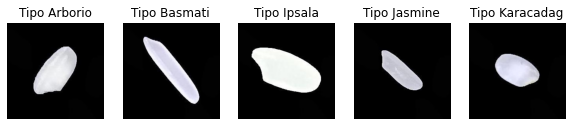

In [12]:
fig, axs = plt.subplots(1,5, figsize=(10, 10))
for ct,i in enumerate(df_combi["label"].unique()):
  testeo = df_combi[df_combi.label == i]
  ubica = testeo.sample().ubica.iloc[0]
  img = Image.open(ubica)
  axs[ct].imshow(img)
  axs[ct].set_title(f'Tipo {i}')
  axs[ct].axis('off')

In [13]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [14]:

def grafica_silhouette(KM,d,titulo):
  silhouette_avg = silhouette_score(d,KM.labels_,metric='euclidean')
  sample_silhouette_values = silhouette_samples(d,KM.labels_,metric='euclidean')

  plt.rcParams['figure.figsize'] = (8,6)
  plt.xlim([-0.1, 1])
  plt.ylim([0, len(KM.labels_) + (k + 1) * 10])

  y_lower = 10
  for i in range(k):
      ith_cluster_silhouette_values = sample_silhouette_values[KM.labels_ == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / k)
      plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10

  plt.title((titulo),
                fontsize=14, fontweight='bold')
  plt.xlabel("The silhouette coefficient values")
  plt.ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  plt.axvline(x=silhouette_avg, color="red", linestyle="--")

  plt.yticks([])  # Clear the yaxis labels / ticks
  plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  plt.show()

In [38]:
def grafica_silhouette_compa(model,d,k,titulo):
  KM = model(n_clusters=k).fit(d)
  silhouette_avg = silhouette_score(d,KM.labels_,metric='euclidean')
  sample_silhouette_values = silhouette_samples(d,KM.labels_,metric='euclidean')

  plt.rcParams['figure.figsize'] = (8,6)
  plt.xlim([-0.1, 1])
  plt.ylim([0, len(KM.labels_) + (k + 1) * 10])

  y_lower = 10
  for i in range(k):
      ith_cluster_silhouette_values = sample_silhouette_values[KM.labels_ == i]

      ith_cluster_silhouette_values.sort()

      size_cluster_i = ith_cluster_silhouette_values.shape[0]
      y_upper = y_lower + size_cluster_i

      color = cm.nipy_spectral(float(i) / k)
      plt.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

      plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

      y_lower = y_upper + 10

  plt.title((titulo),
                fontsize=14, fontweight='bold')
  plt.xlabel("The silhouette coefficient values")
  plt.ylabel("Cluster label")

  # The vertical line for average silhouette score of all the values
  plt.axvline(x=silhouette_avg, color="red", linestyle="--")

  plt.yticks([])  # Clear the yaxis labels / ticks
  plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  plt.show()

In [26]:
#names, feat = preprocess(completo, model)

In [15]:
#Guardo en pickle el modelo
#pickle.dump(names, open('names-5k-img.pk1','wb'))
#pickle.dump(feat, open('feat-5k-img.pk1','wb'))

#Cargo el modelo
names = pickle.load(open('names-5k-img.pk1','rb'))
feat = pickle.load(open('feat-5k-img.pk1','rb'))


In [68]:
# get the unique labels

#label = df_combi['label'].tolist()
#unique_labels = list(set(label))
#unique_labels

['Karacadag', 'Arborio', 'Jasmine', 'Basmati', 'Ipsala']

In [16]:
#Valores con PCA 
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [100]:
#d_meta = gower.gower_matrix(x)
#Tarda mas de 23 minutos con 25k de imagenes, la matriz de gower tarda 5 minutos con la misma cantidad de img 
#import seaborn as sns
#sns.clustermap(d_meta)

In [17]:
#Para fijar los colores en los gráficos
import matplotlib as mpl
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', plt.cm.tab10(np.arange(6)), 6)

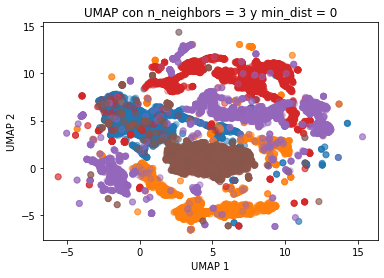

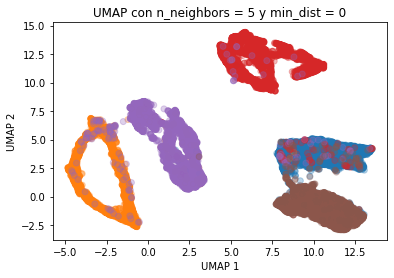

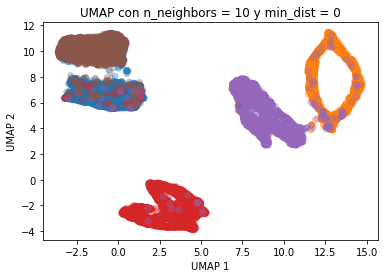

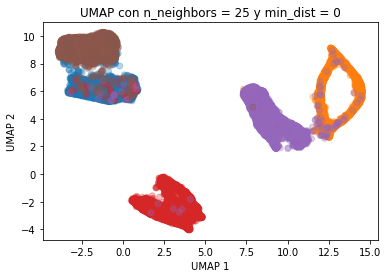

In [38]:
#Reduccion de dimensiones con UMAP
n_vecinos = [3,5,10,25]
for i in n_vecinos:
    um = UMAP(n_neighbors=i,min_dist=0)
    Xmap = um.fit_transform(feat)
    plt.scatter(Xmap[:,0],Xmap[:,1],c=df_combi.label_num,cmap=cmap,alpha=0.3)    
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title(f"UMAP con n_neighbors = {i} y min_dist = 0")
    plt.show()

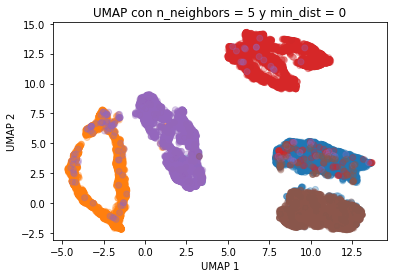

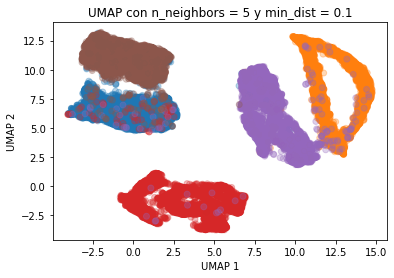

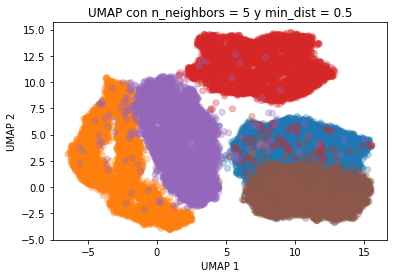

In [22]:
min_distan = [0,0.1,0.5]
for i in min_distan:
    um = UMAP(n_neighbors=5,min_dist=i)
    Xmap = um.fit_transform(feat)
    plt.scatter(Xmap[:,0],Xmap[:,1],c=df_combi.label_num,cmap=cmap,alpha=0.3)    
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title(f"UMAP con n_neighbors = 5 y min_dist = {i}")
    plt.show()

In [59]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 100


In [71]:
um = UMAP(n_neighbors=5,min_dist=0)
Xmap = um.fit_transform(feat)

In [72]:
kmeans_map = KMeans(n_clusters=5)
kmeans_map.fit(Xmap)

KMeans(n_clusters=5)

In [73]:
kmeans_pca =KMeans(n_clusters=5)
kmeans_pca.fit(x)

KMeans(n_clusters=5)

In [21]:
groups = {}
for file, cluster in zip(names,kmeans_map.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

Clipping cluster size from 5076 to 10
Clipping cluster size from 6247 to 10
Clipping cluster size from 4901 to 10
Clipping cluster size from 3771 to 10
Clipping cluster size from 5005 to 10


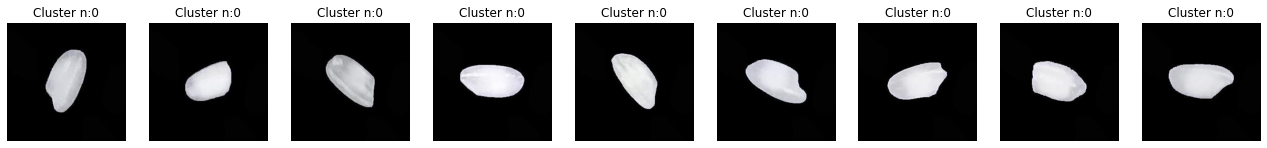

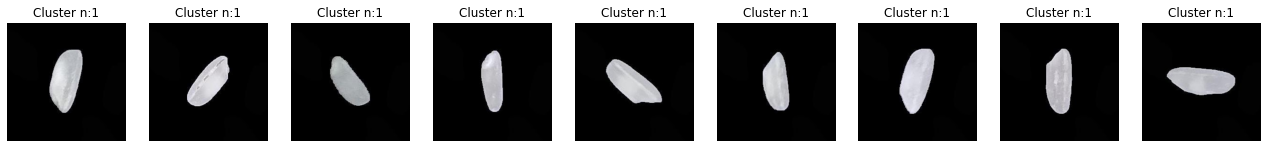

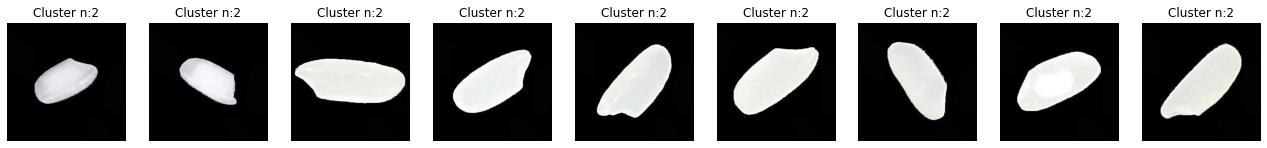

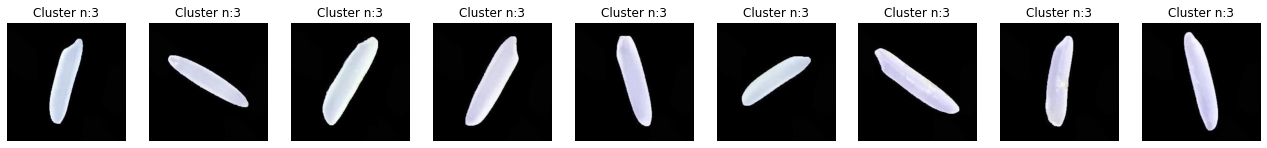

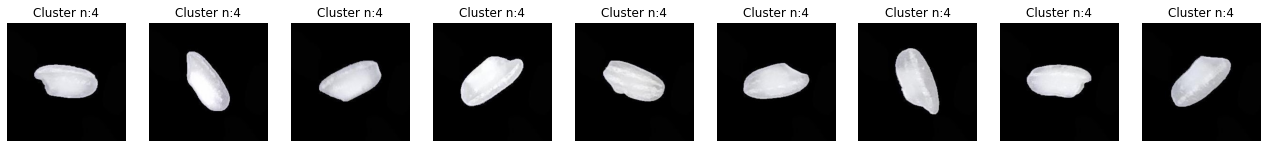

In [22]:
for n in range(len(groups)):
  view_cluster(groups[n],n)

In [74]:
def graficar_modelos(x_pca,x_umap,modelo_pca,modelo_umap,labels_reales= df_combi["label_num"],titulo="Inserte titulo"):
    fig, axs = plt.subplots(3,2,figsize=(15,15))
    axs[0,0].plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
    axs[0,0].set_xlim([0,15])
    axs[0,0].set_xlabel('PCs')
    axs[0,0].set_ylabel('Var. explicada (%)')
    axs[0,0].set_title("Variabilidad explicada en (%) PCA")
    axs[0,1].axis('off')
    
    axs[1,0].scatter(x_pca[:,0],x_pca[:,1],s=5,c=modelo_pca.labels_, alpha=0.5)
    axs[1,0].set_xlabel('PC1')
    axs[1,0].set_ylabel('PC2')
    axs[1,0].set_title("Componenetes principales PCA con labels del modelo")
    axs[2,0].scatter(x_pca[:,0],x_pca[:,1],s=5,c=labels_reales, alpha=0.5)
    axs[2,0].set_xlabel('PC1')
    axs[2,0].set_ylabel('PC2')
    axs[2,0].set_title("Labels reales en las PC1 y PC2")
    axs[1,1].scatter(x_umap[:,0],x_umap[:,1],s=5,c=modelo_umap.labels_, alpha=0.5)
    axs[1,1].set_xlabel('UMAP 1')
    axs[1,1].set_ylabel('UMAP 2')
    axs[1,1].set_title("Componenentes principales UMAP con labels del modelo")
    axs[2,1].scatter(x_umap[:,0],x_umap[:,1],s=5,c=labels_reales, alpha=0.5)
    axs[2,1].set_xlabel('UMAP 1')
    axs[2,1].set_ylabel('UMAP 2')
    axs[2,1].set_title("Labels reales en las UMAP1 y UMAP2")

    fig.suptitle(titulo, fontsize=36)


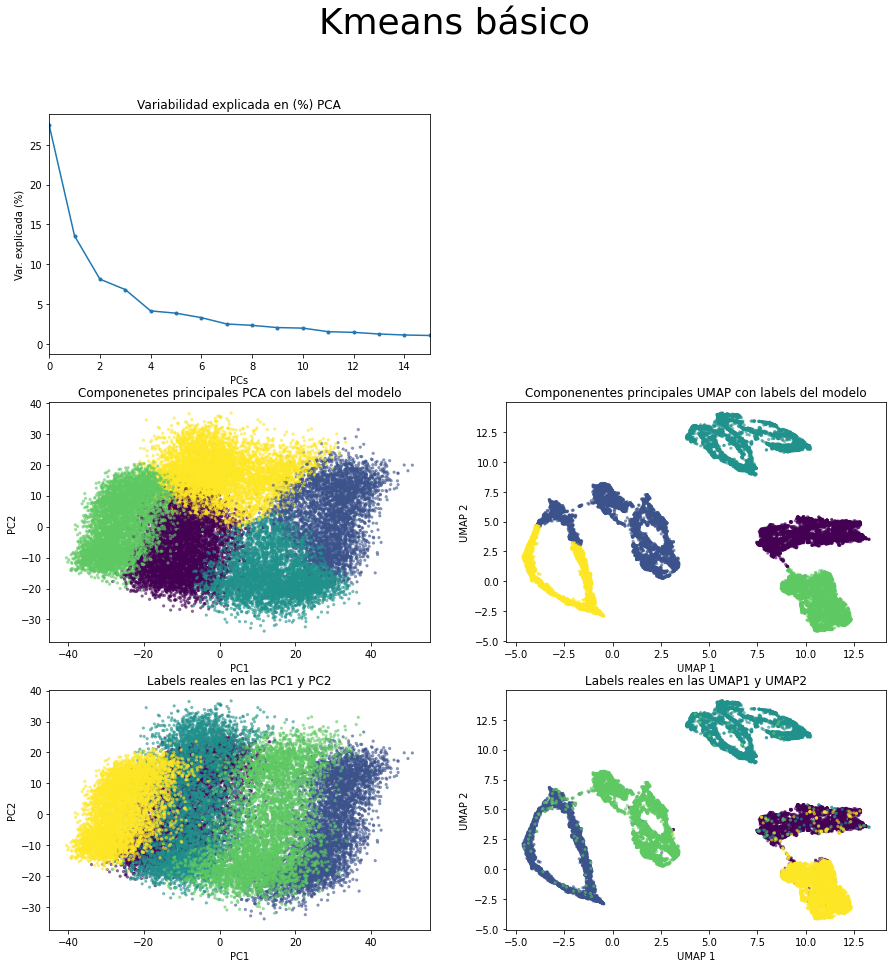

In [76]:
#Kmeans básico
graficar_modelos(x,Xmap,kmeans_pca,kmeans_map,titulo="Kmeans básico")

In [77]:
def score_pca(modelo,pca_x,umap_x,r=range(2,10),titulo="Modelo"):
    fig, axs = plt.subplots(2,2,figsize=(15,15))
    k_x =  [x for x in r]
    silh = []
    sse= []
    silh_umap = []
    for k in r:
        model = modelo(n_clusters=k).fit(pca_x)
        silh.append(silhouette_score(pca_x,model.labels_))
        sse.append(sum_sse(model))
    for k in r:
        model_umap = modelo(n_clusters=k).fit(umap_x)
        silh_umap.append(silhouette_score(umap_x,model_umap.labels_))
    #PCA     
    axs[0,0].plot(k_x,silh,'r.-')
    axs[0,0].set_ylabel('Silhuette promedio')
    axs[0,0].set_xlabel('k')
    axs[1,0].plot(k_x,sse)
    axs[1,0].set_ylabel('SSE')  
    axs[0,0].set_title("Silhuette promedio para PCA en diferentes k")
    axs[1,0].set_title("SSE para PCA en diferentes k")
    #UMAP
    axs[0,1].plot(k_x,silh_umap,'r.-')
    axs[0,1].set_ylabel('Silhuette promedio') 
    axs[0,1].set_xlabel('k') 
    axs[0,1].set_title("Silhuette promedio para UMAP en diferentes k")
    axs[1,1].axis('off')
    
    fig.suptitle(f"Silhuette promedio vs k para {titulo}", fontsize=36)

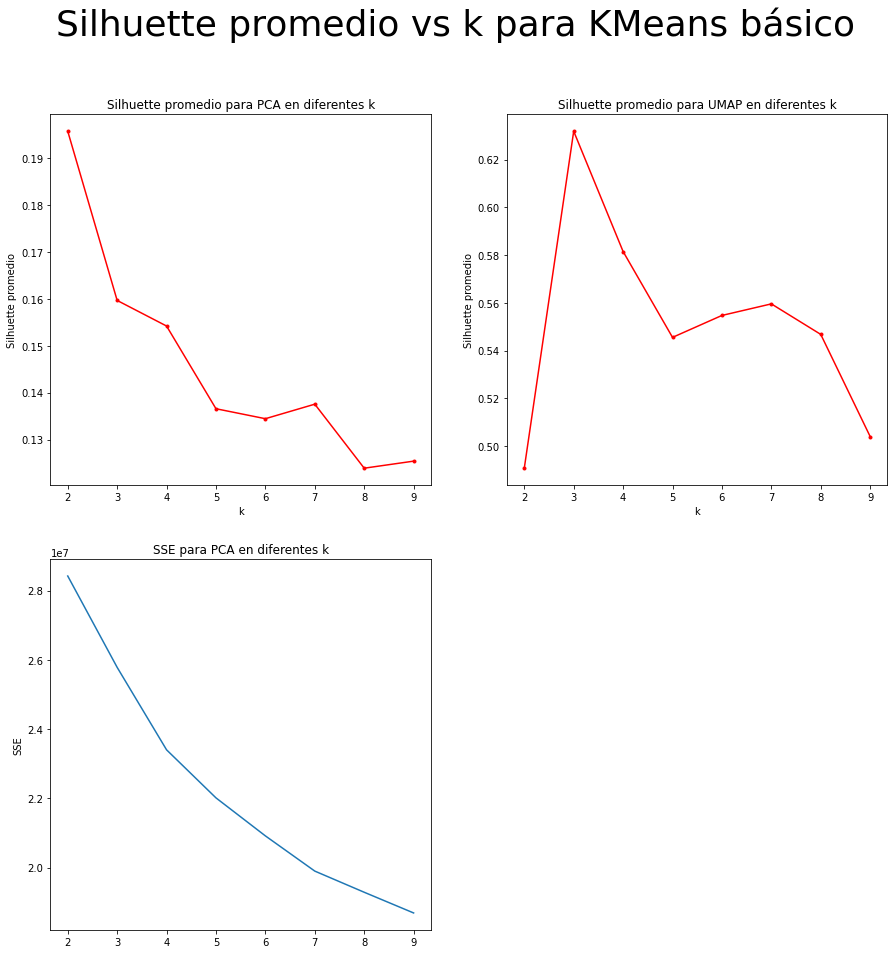

In [83]:
score_pca(KMeans,x,Xmap,range(2,10),"KMeans básico")

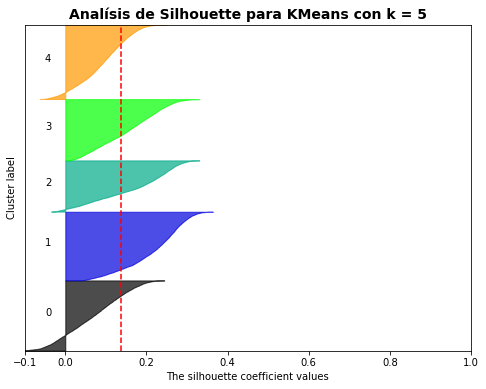

In [85]:
k = 5
titulo = "Analísis de Silhouette para KMeans con k = 5 y PCA"
grafica_silhouette(kmeans_pca,x,titulo)

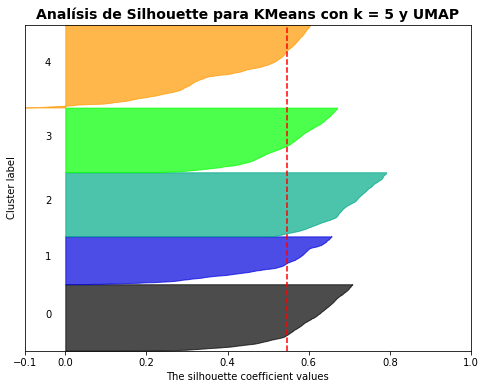

In [86]:
k = 5
titulo = "Analísis de Silhouette para KMeans con k = 5 y UMAP"
grafica_silhouette(kmeans_map,Xmap,titulo)

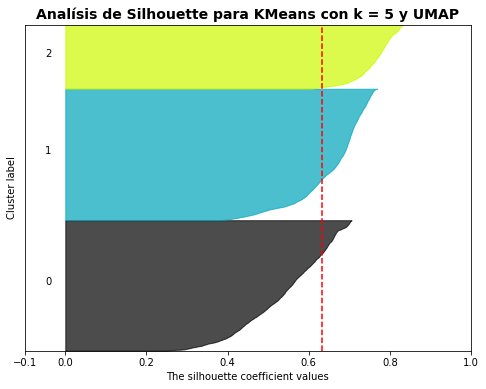

In [39]:
k = 3
titulo = "Analísis de Silhouette para KMeans con k = 3 y UMAP"
grafica_silhouette_compa(KMeans,Xmap,k,titulo)

In [183]:
#Scores con KMeans para PCA y k = 5
nom_mode = "KMeans con PCA y k = 5"

print(f"Rand score ajustado {nom_mode}: ", round(adjusted_rand_score(df_combi["label_num"],kmeans_pca.labels_),4))
#vanDongen 
df_combi["predicted"] = kmeans_pca.labels_

df_van = df_combi[["label_num","predicted"]]
print(f"vanDongen para {nom_mode}: ", round(vanDongen(df_van),4))

Rand score ajustado KMeans con PCA y k = 5:  0.4334
vanDongen para KMeans con PCA y k = 5:  0.8996


In [184]:
#Agrupamiento predecido vs real Kmeans en PCA
df_combi.groupby(by=["label","predicted"]).count()

ubica  file  label_num
label     predicted                        
Arborio   0           2734  2734       2734
          1              7     7          7
          2             47    47         47
          3            504   504        504
          4           1708  1708       1708
Basmati   1           3278  3278       3278
          2           1712  1712       1712
          4             10    10         10
Ipsala    0           2645  2645       2645
          1              1     1          1
          2            110   110        110
          3             25    25         25
          4           2219  2219       2219
Jasmine   0            190   190        190
          1            696   696        696
          2           2836  2836       2836
          3              3     3          3
          4           1275  1275       1275
Karacadag 0             77    77         77
          3           4738  4738       4738
          4            185   185        185

In [181]:
#Scores con KMeans para UMAP y k = 5
nom_mode = "Kmeans con UMAP y k = 5"

print(f"Rand score ajustado {nom_mode}: ", round(adjusted_rand_score(df_combi["label_num"],kmeans_map.labels_),4))
#vanDongen 
df_combi["predicted"] = kmeans_map.labels_

df_van = df_combi[["label_num","predicted"]]
print(f"vanDongen para {nom_mode}: ", round(vanDongen(df_van),4))

Rand score ajustado Kmeans con UMAP y k = 5:  0.8417
vanDongen para Kmeans con UMAP y k = 5:  0.9184


In [182]:
#Agrupamiento predecido vs real KMeeans en UMAP
df_combi.groupby(by=["label","predicted"]).count()

ubica  file  label_num
label     predicted                        
Arborio   0           4793  4793       4793
          1             20    20         20
          2              3     3          3
          3            184   184        184
Basmati   0              1     1          1
          1           1326  1326       1326
          4           3673  3673       3673
Ipsala    0             60    60         60
          1             38    38         38
          2           4901  4901       4901
          3              1     1          1
Jasmine   0             28    28         28
          1           4920  4920       4920
          2             17    17         17
          3              1     1          1
          4             34    34         34
Karacadag 0             78    78         78
          1              1     1          1
          3           4921  4921       4921

In [80]:
# Segundo modelo Kmedoids
from sklearn_extra.cluster import KMedoids
cant_clusters = 5
KM_meta_pca=KMedoids(n_clusters=cant_clusters,init='k-medoids++').fit(x)

KM_meta_map=KMedoids(n_clusters=cant_clusters, init='k-medoids++').fit(Xmap)

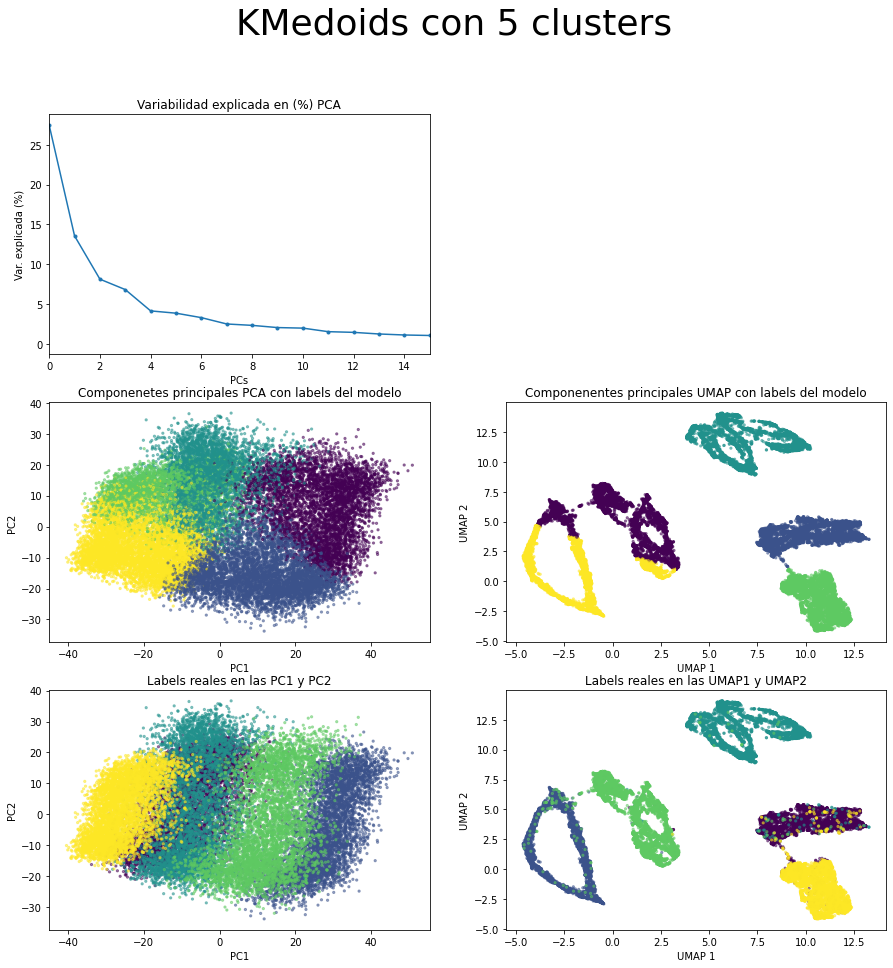

In [82]:
graficar_modelos(x,Xmap,KM_meta_pca,KM_meta_map,titulo="KMedoids con 5 clusters")

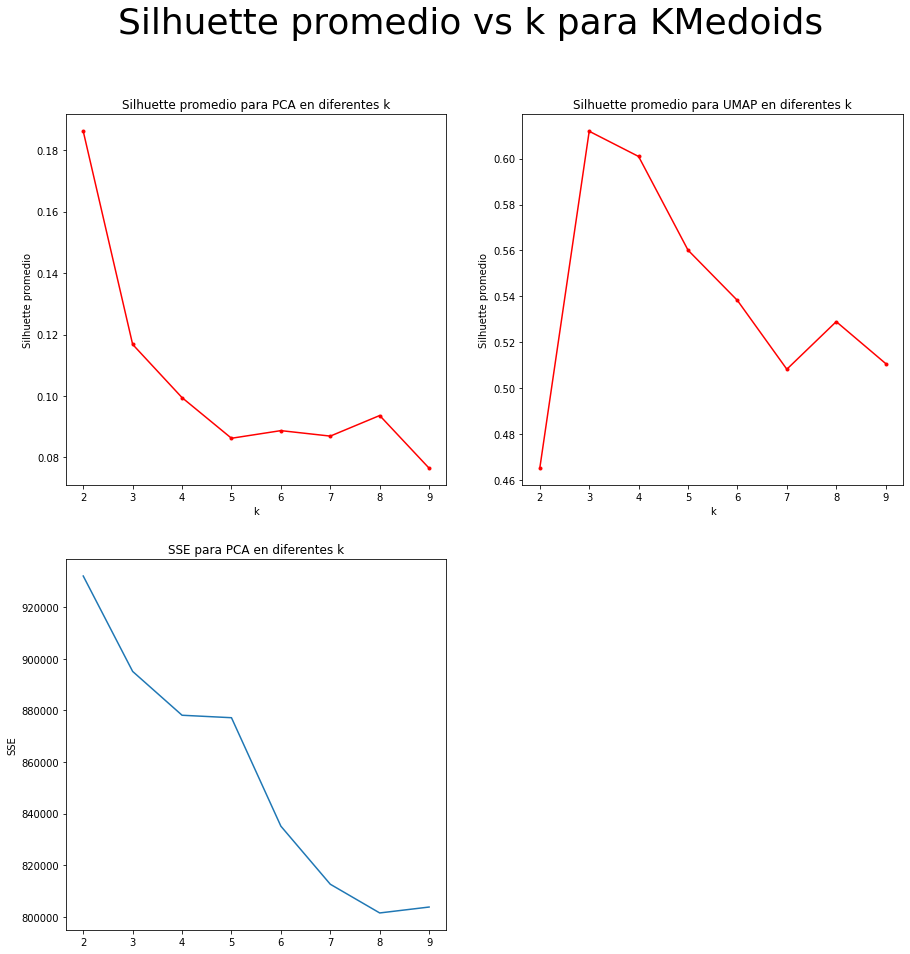

In [87]:
score_pca(KMedoids,x,Xmap,range(2,10),"KMedoids")

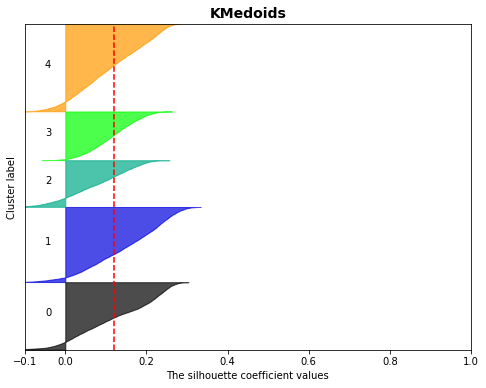

In [88]:
titulo = "KMedoids PCA"
k = 5
grafica_silhouette(KM_meta_pca,x,titulo)

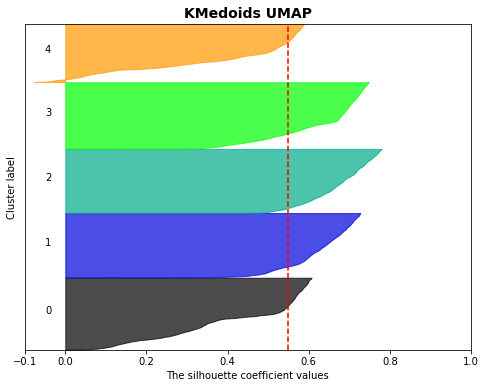

In [90]:
titulo = "KMedoids UMAP"
k = 5
grafica_silhouette(KM_meta_map,Xmap,titulo)

In [179]:
#Scores con KMedoids para PCA y k = 5
nom_mode = "KMedoids con PCA y k = 5"
modelo_para_score = KM_meta_pca

print(f"Rand score ajustado {nom_mode}: ", round(adjusted_rand_score(df_combi["label_num"],modelo_para_score.labels_),4))
#vanDongen 
df_combi["predicted"] = modelo_para_score.labels_

df_van = df_combi[["label_num","predicted"]]
print(f"vanDongen para {nom_mode}: ", round(vanDongen(df_van),4))

Rand score ajustado KMedoids con PCA y k = 5:  0.2995
vanDongen para KMedoids con PCA y k = 5:  0.8862


In [180]:
#Agrupamiento predecido vs real KMedoids en PCA
df_combi.groupby(by=["label","predicted"]).count()

ubica  file  label_num
label     predicted                        
Arborio   0            182   182        182
          1            318   318        318
          2            577   577        577
          3           1887  1887       1887
          4           2036  2036       2036
Basmati   0           3326  3326       3326
          1           1673  1673       1673
          2              1     1          1
Ipsala    0              6     6          6
          1            832   832        832
          2           2654  2654       2654
          3             71    71         71
          4           1437  1437       1437
Jasmine   0           1672  1672       1672
          1           2947  2947       2947
          2            347   347        347
          3             29    29         29
          4              5     5          5
Karacadag 2              2     2          2
          3           1750  1750       1750
          4           3248  3248       3248

In [177]:
#Scores con KMedoids para UMAP y k = 5
nom_mode = "KMedoids con PCA y k = 5"
modelo_para_score = KM_meta_map

print(f"Rand score ajustado {nom_mode}: ", round(adjusted_rand_score(df_combi["label_num"],modelo_para_score.labels_),4))
#vanDongen 
df_combi["predicted"] = modelo_para_score.labels_

df_van = df_combi[["label_num","predicted"]]
print(f"vanDongen para {nom_mode}: ", round(vanDongen(df_van),4))

Rand score ajustado KMedoids con PCA y k = 5:  0.8093
vanDongen para KMedoids con PCA y k = 5:  0.8803


In [178]:
#Agrupamiento predecido vs real KMedoids en UMAP
df_combi.groupby(by=["label","predicted"]).count()

ubica  file  label_num
label     predicted                        
Arborio   0             19    19         19
          1           4793  4793       4793
          2              3     3          3
          3            184   184        184
          4              1     1          1
Basmati   0           1175  1175       1175
          1              1     1          1
          4           3824  3824       3824
Ipsala    0             34    34         34
          1             60    60         60
          2           4901  4901       4901
          3              1     1          1
          4              4     4          4
Jasmine   0           4301  4301       4301
          1             28    28         28
          2             17    17         17
          3              1     1          1
          4            653   653        653
Karacadag 0              1     1          1
          1             78    78         78
          3           4921  4921       4921

In [102]:
from sklearn.cluster import HDBSCAN

hdbscan_pca = HDBSCAN(min_cluster_size=20).fit(x)


In [101]:
hdbscan_map = HDBSCAN(min_cluster_size=20).fit(Xmap)

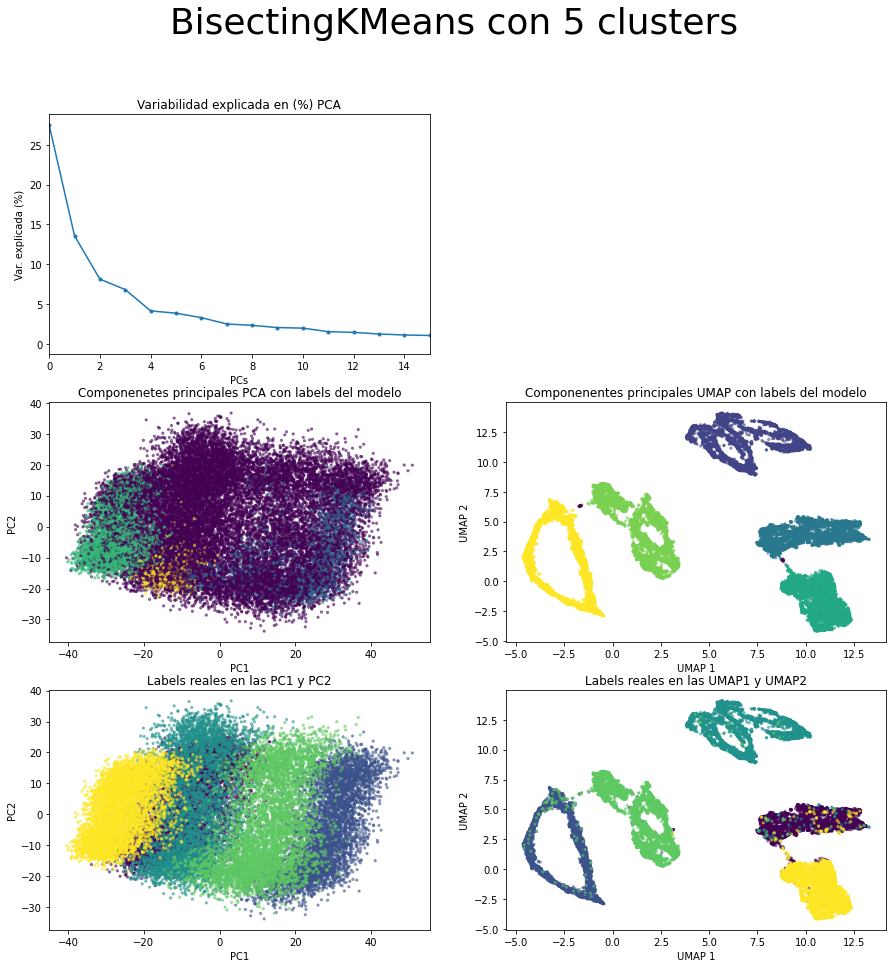

In [96]:
graficar_modelos(x,Xmap,hdbscan_pca,hdbscan_map,titulo="HDBSCAN con min_cluster_size=20")

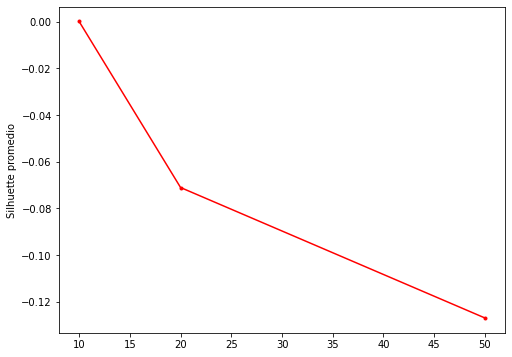

In [97]:
range_k = [10,20,50]
silh = []
sse = []
for k in range_k:    
    model_calc = HDBSCAN(min_cluster_size=k).fit(x) 
    silh.append(silhouette_score(x,model_calc.labels_))
    #sse.append(sum_sse(model_calc))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

#plt.plot(range_k,sse)
#plt.ylabel('SSE')
#plt.show()




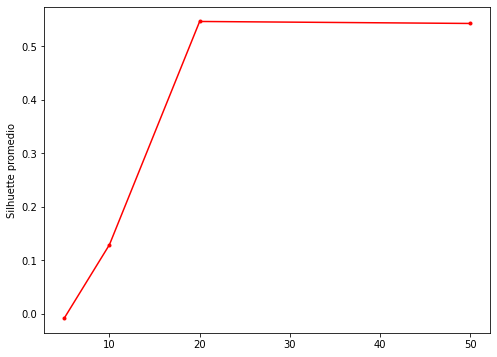

In [99]:
range_k = [5,10,20,50]
silh = []
sse = []
for k in range_k:    
    model_calc = HDBSCAN(min_cluster_size=k).fit(Xmap) 
    silh.append(silhouette_score(Xmap,model_calc.labels_))
    #sse.append(sum_sse(model_calc))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

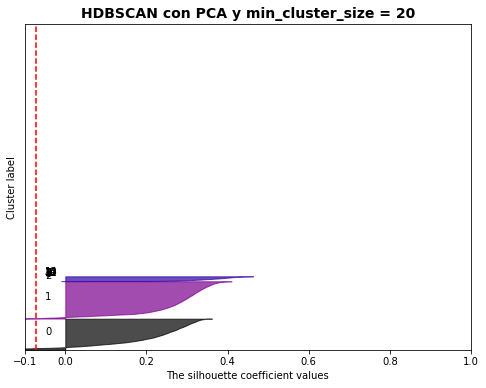

In [106]:
titulo = "HDBSCAN con PCA y min_cluster_size = 20"
k = 15
grafica_silhouette(hdbscan_pca,x,titulo)

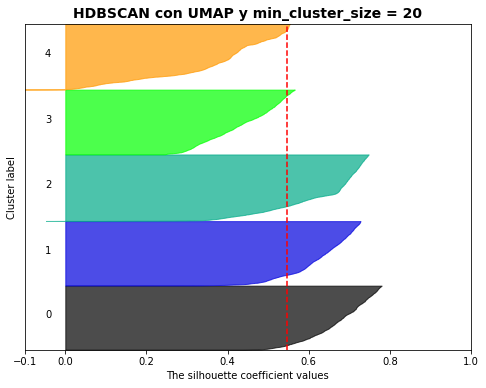

In [105]:
titulo = "HDBSCAN con UMAP y min_cluster_size = 20"
k = 5
grafica_silhouette(hdbscan_map,Xmap,titulo)

In [174]:
#Scores con KMedoids para PCA y k = 5
nom_mode = "HDBSCAN con PCA"
modelo_para_score = hdbscan_pca

print(f"Rand score ajustado {nom_mode}: ", round(adjusted_rand_score(df_combi["label_num"],modelo_para_score.labels_),4))
#vanDongen 
df_combi["predicted"] = modelo_para_score.labels_

df_van = df_combi[["label_num","predicted"]]
print(f"vanDongen para {nom_mode}: ", round(vanDongen(df_van),4))

Rand score ajustado HDBSCAN con PCA:  0.0609
vanDongen para HDBSCAN con PCA:  0.9815


In [175]:
#Agrupamiento predecido vs real DBSCAN en PCA
df_combi.groupby(by=["label","predicted"]).count()

ubica  file  label_num
label     predicted                        
Arborio   -1          4659  4659       4659
           1           341   341        341
Basmati   -1          3297  3297       3297
           0          1703  1703       1703
Ipsala    -1          4628  4628       4628
           2           372   372        372
Jasmine   -1          4310  4310       4310
           0           689   689        689
           1             1     1          1
Karacadag -1          2465  2465       2465
           1          2535  2535       2535

In [108]:
#Scores con KMedoids para PCA y k = 5
nom_mode = "HDBSCAN con UMAP"
modelo_para_score = hdbscan_map

print(f"Rand score ajustado {nom_mode}: ", round(adjusted_rand_score(df_combi["label_num"],modelo_para_score.labels_),4))
#vanDongen 
df_combi["predicted"] = modelo_para_score.labels_

df_van = df_combi[["label_num","predicted"]]
print(f"vanDongen para {nom_mode}: ", round(vanDongen(df_van),4))

Rand score ajustado HDBSCAN con UMAP:  0.9444
vanDongen para HDBSCAN con UMAP:  0.8662


In [173]:
#DBSCAN agrupamiento predecido vs real
df_combi.groupby(by=["label","predicted"]).count()

ubica  file  label_num
label     predicted                        
Arborio   -1             5     5          5
           0             3     3          3
           1          4787  4787       4787
           2           185   185        185
           3            20    20         20
Basmati   -1             4     4          4
           1             1     1          1
           3            50    50         50
           4          4945  4945       4945
Ipsala     0          4901  4901       4901
           1            60    60         60
           2             1     1          1
           3            38    38         38
Jasmine   -1             7     7          7
           0            17    17         17
           1            28    28         28
           2             1     1          1
           3          4864  4864       4864
           4            83    83         83
Karacadag -1             3     3          3
           1            71    71         71
           2          4925  4925       4925
           3             1     1          1

In [112]:
#Desde acá punto 7
import imageio.v3 as iio
import ipympl
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski

In [110]:
df_combi["ubica"][0]

'C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (1).jpg'

In [110]:
def connected_components(filename, sigma=1.0, t=0.5, connectivity=2):
    # load the image
    image = iio.imread(filename)
    # convert the image to grayscale
    gray_image = ski.color.rgb2gray(image)
    # denoise the image with a Gaussian filter
    blurred_image = ski.filters.gaussian(gray_image, sigma=sigma)
    # mask the image according to threshold
    binary_mask = blurred_image < t
    # perform connected component analysis
    labeled_image, count = ski.measure.label(binary_mask,
                                                 connectivity=connectivity, return_num=True)
    return labeled_image, count

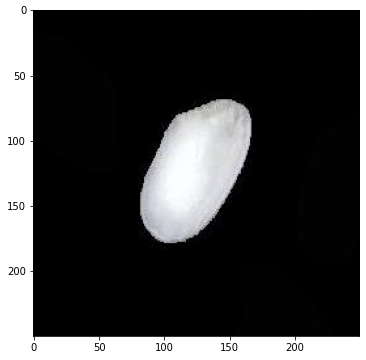

In [117]:
imagen = iio.imread("C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (6).jpg")
plt.imshow(imagen)

(-0.5, 249.5, 249.5, -0.5)

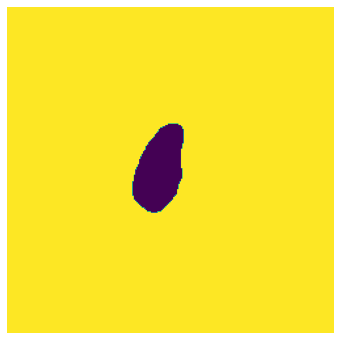

In [115]:
labeled_image, count = connected_components(filename="C:\\Users\\lrktl\\OneDrive\\Escritorio\\Maestria\\Primero\\Ciencia\\Tps\\Tp 1\\Img\\Arborio\\Arborio (6).jpg", sigma=2.0, t=0.9, connectivity=2)

fig, ax = plt.subplots()
plt.imshow(labeled_image)
plt.axis("off")

<function matplotlib.pyplot.show(block=None)>

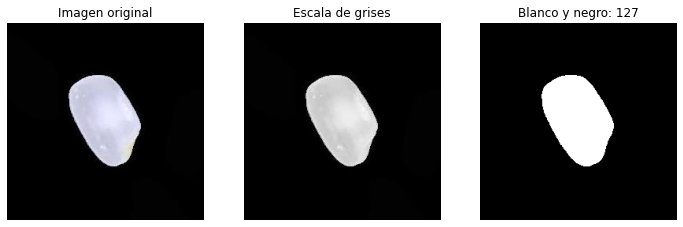

In [125]:
#Imagen en color, escala de grises y blanco y negro

fig, axs = plt.subplots(1, 3, figsize=(12, 12))
img = cv2.imread(path[0])
img_col = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
(thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
axs[0].imshow(img_col)
axs[0].set_title('Imagen original')
axs[0].axis('off')
axs[1].imshow(grayImage,cmap='gray')
axs[1].set_title('Escala de grises')
axs[1].axis('off')
axs[2].imshow(blackAndWhiteImage,cmap='gray')
axs[2].set_title('Blanco y negro: 127')
axs[2].axis('off')

plt.show

Text(0.5, 1.0, 'Image after Component Labeling')

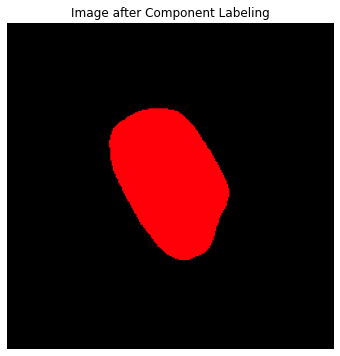

In [142]:
num_labels, labels = cv2.connectedComponents(blackAndWhiteImage)

label_hue = np.uint8(179*labels/np.max(labels))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

# Converting cvt to BGR
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

# set bg label to black
labeled_img[label_hue==0] = 0

plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Image after Component Labeling")   


Text(0.5, 1.0, 'Orginal Image')

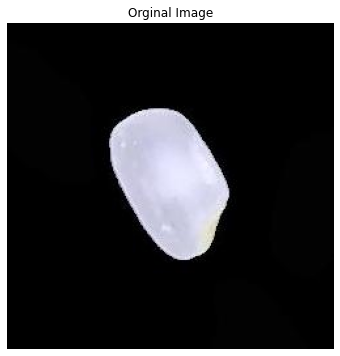

In [141]:
# Showing Original Image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Orginal Image")

In [143]:
def connected_component_label(path):
    
    # Getting the input image
    img = cv2.imread(path, 0)
    # Converting those pixels with values 1-127 to 0 and others to 1
    img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]
    # Applying cv2.connectedComponents() 
    num_labels, labels = cv2.connectedComponents(img)
    
    # Map component labels to hue val, 0-179 is the hue range in OpenCV
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # Converting cvt to BGR
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0
    
    
    # Showing Original Image
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    #plt.axis("off")
    #plt.title("Orginal Image")
    
    
    #Showing Image after Component Labeling
    plt.imshow(cv2.cvtColor(labeled_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Image after Component Labeling")
    



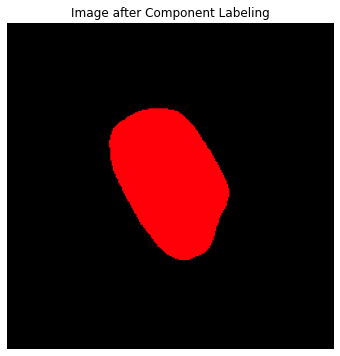

In [139]:
connected_component_label(path[0])